<a href="https://colab.research.google.com/github/psagar123/RuralHeatIsland/blob/main/wbgt_heatwave_2020_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This script corresponds to the manuscript submitted to AGU-GeoHealth titled "High-resolution modeling of wet-bulb globe temperature reveals substantial heat risks among agricultural workers in Southern California".

## This script shows how to calculate number of heatwave days using different definitions (e.g. CCR). This script also demonstrates how to calculate WBGT from WRF outputs using the python script developed by Kong and Huber (2022) which is available at:
https://github.com/QINQINKONG/PyWBGT

## In particular this script corresponds to Fig. 8 and 9 in the manuscript.





In [22]:
# mount the google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# First read CIMIS station air-temperature data (for Imperial Valley)

import pandas as pd
import numpy as np

# Read the CSV file into a pandas DataFrame
airtemp_2020 = pd.read_csv(r'/content/drive/MyDrive/python_colab_data/Station_data/CIMIS/cimis_hourly.csv')
airtemp_2020

# Data are complete for 2020 on hourly basis

# find the unique stations inside the Imperial County, this will be used for plotting stations later

Stn_Name = airtemp_2020['Stn Name'].unique()

latitude = [33.04399, 32.759, 32.807, 33.389, 33.0786]
longitude = [-115.415, -115.732, -115.446, -114.726, -115.661]

data = {'Stn_Name': Stn_Name, 'latitude': latitude, 'longitude': longitude}
unique_stations = pd.DataFrame(data)
print(unique_stations)

selected_data_temp = airtemp_2020[['Air Temp (F)']]
# selected_data has 5 stations * 24 * 366 = 43920 obs for 2020

stn_array_temp = selected_data_temp.to_numpy()
stn_array_temp.shape

reshaped_stn_array_temp = stn_array_temp.reshape(5, 8784)
reshaped_stn_array_sep_temp = reshaped_stn_array_temp[:, :];
print(reshaped_stn_array_sep_temp.shape)

              Stn_Name  latitude  longitude
0  Calipatria/Mulberry  33.04399   -115.415
1               Seeley  32.75900   -115.732
2             Meloland  32.80700   -115.446
3        Palo Verde II  33.38900   -114.726
4    Westmorland North  33.07860   -115.661
(5, 8784)


In [24]:
#  Now read CARB station data (for Coachella Valley)

import pandas as pd

# Read the CSV file into a pandas DataFrame
airtemp_2020 = pd.read_csv(r'/content/drive/MyDrive/python_colab_data/Station_data/otemp.2020/otemp.2020.csv')
airtemp_2020.head()

# Extract rows where county_name is equal to 'Imperial' only

airtemp_2020_imp = airtemp_2020[airtemp_2020['county_name'] == 'Riverside']
del airtemp_2020
# Extract rows where obs_type is equal to 'H' corresponding to hourly data from airtemp_2020_imp
airtemp_2020_imp_hourly = airtemp_2020_imp[airtemp_2020_imp['obs_type'] == 'H']
del airtemp_2020_imp
airtemp_2020_imp_hourly.head()

# Find the unique stations inside the Imperial County, this will be used for plotting stations later

unique_county_names = airtemp_2020_imp_hourly['name'].unique()

unique_stations_temp = airtemp_2020_imp_hourly[['name', 'latitude', 'longitude']].drop_duplicates()
print(unique_stations_temp)


from datetime import datetime

start_date = '2020-01-01'
end_date = '2020-12-31'

mask = (airtemp_2020_imp_hourly['date'] >= start_date) & (airtemp_2020_imp_hourly['date'] <= end_date)

# Extract rows between the specified date range
airtemp_2020_imp_hourly_apr = airtemp_2020_imp_hourly.loc[mask]

airtemp_2020_imp_hourly_apr = airtemp_2020_imp_hourly_apr.copy() # this was necessary to avoid an error which didn't allow adding 'datetime' column
airtemp_2020_imp_hourly_apr['datetime'] = pd.to_datetime(airtemp_2020_imp_hourly_apr['date']) + pd.to_timedelta(airtemp_2020_imp_hourly_apr['start_hour'], unit='h')

# Resample station data to make hourly

mask = (airtemp_2020_imp_hourly['date'] >= start_date) & (airtemp_2020_imp_hourly['date'] <= end_date)

# Extract rows between the specified date range
airtemp_2020_imp_hourly_apr = airtemp_2020_imp_hourly.loc[mask]
airtemp_2020_imp_hourly_apr['datetime'] = pd.to_datetime(airtemp_2020_imp_hourly_apr['date']) + pd.to_timedelta(airtemp_2020_imp_hourly_apr['start_hour'], unit='h')

airtemp_2020_imp_hourly_apr.set_index('datetime', inplace=True)

hourly_resampled_data_stns_temp = airtemp_2020_imp_hourly_apr.groupby(['name', 'datetime'])['obs'].mean().unstack() #  it already excludes Calexico because it has no data
# Reindex to ensure all 8784 hours are included
full_time_index = pd.date_range('2020-01-01 00:00', '2020-12-31 23:00', freq='h')
hourly_resampled_data_stns_temp = hourly_resampled_data_stns_temp.reindex(columns=full_time_index)

hourly_resampled_data_stns_array_temp = hourly_resampled_data_stns_temp.to_numpy()
hourly_resampled_data_stns_array_temp.shape



/tmp/ipython-input-24-687421304.py:6: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  airtemp_2020 = pd.read_csv(r'/content/drive/MyDrive/python_colab_data/Station_data/otemp.2020/otemp.2020.csv')


                                             name   latitude   longitude
3751369                           Banning Airport  33.920767 -116.858413
3753561                               Beaumont #3  33.930600 -116.940000
3788564                                    Corona  33.874444 -117.549167
3833689                      Indio-Jackson Street  33.708573 -116.215395
3844654  Joshua Tree NP-Cottonwood #2              33.747236 -115.820124
3868682              Lake Elsinore-W Flint Street  33.676530 -117.331040
3888326                Mecca-65705 Johnson Street  33.572020 -116.063820
3916633                       Mira Loma Van Buren  33.996360 -117.492400
3934034                 Palm Springs-Fire Station  33.852620 -116.540990
3951737                                    Perris  33.789330 -117.227640
3953940                                    PINYON  33.577800 -116.454000
4005381                        Riverside-Rubidoux  33.999520 -117.415950
4007573                           Salton Sea Park  

(16, 8784)

In [25]:
import numpy as np

# Combine two stations to be used (Seeley and Palm Springs) in one array

# Extract row index 4 from the first array and row index 2 from the second
row1 = reshaped_stn_array_sep_temp[1, :] # Seeley
row2 = hourly_resampled_data_stns_array_temp[8, :] * 9 / 5 + 32 # Palm Springs

# Stack them into a new array of shape (2, 8784)
combined_array = np.vstack([row1, row2])
combined_array.shape

(2, 8784)

In [26]:
# calculate heatwave days using WMO criteria (i.e. 95C for more than 3 consecutive days)

from calendar import monthrange

# Step 1: Extract first two stations
data_2stations = combined_array;

import numpy as np
from datetime import datetime, timedelta


# Step 2: Reshape to daily max temps: (2, 366 days, 24 hours)
data_daily_max = data_2stations.reshape(2, 366, 24).max(axis=2)  # shape: (2, 366)

# Step 3: Apply fixed threshold
threshold_fixed = 95.0  # °F
heat_flags_fixed = data_daily_max >= threshold_fixed  # shape: (2, 366)

# Step 4: Identify consecutive hot days (≥3)
def identify_heatwaves_fixed(flags):
    hw_periods = []
    count = 0
    start = None
    for i, val in enumerate(flags):
        if val:
            if count == 0:
                start = i
            count += 1
        else:
            if count >= 5:
                hw_periods.append((start, i - 1))
            count = 0
    if count >= 5:
        hw_periods.append((start, len(flags) - 1))
    return hw_periods

hw_fixed_stn0 = identify_heatwaves_fixed(heat_flags_fixed[0])
hw_fixed_stn1 = identify_heatwaves_fixed(heat_flags_fixed[1])

# Step 5: Convert index to date
def day_indices_to_dates(start_idx, end_idx):
    base = datetime(2020, 1, 1)
    return [(base + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(start_idx, end_idx + 1)]

# Step 6: Print heatwave periods
def print_station_heatwaves(station_id, hw_periods, data_daily_max):
    print(f"\nHeatwaves for station {station_id} (≥ 95°F):")
    if not hw_periods:
        print("  No heatwaves detected.")
        return
    for start, end in hw_periods:
        dates = day_indices_to_dates(start, end)
        temps = data_daily_max[station_id, start:end+1]
        print(f"  {dates[0]} to {dates[-1]} ({end - start + 1} days):")
        for d, t in zip(dates, temps):
            print(f"    {d}: {t:.2f} °F")

# Step 7: Output
print_station_heatwaves(0, hw_fixed_stn0, data_daily_max)
print_station_heatwaves(1, hw_fixed_stn1, data_daily_max)




Heatwaves for station 0 (≥ 95°F):
  2020-04-22 to 2020-05-11 (20 days):
    2020-04-22: 95.50 °F
    2020-04-23: 97.90 °F
    2020-04-24: 99.80 °F
    2020-04-25: 101.70 °F
    2020-04-26: 103.70 °F
    2020-04-27: 100.50 °F
    2020-04-28: 102.70 °F
    2020-04-29: 103.50 °F
    2020-04-30: 99.80 °F
    2020-05-01: 101.40 °F
    2020-05-02: 97.10 °F
    2020-05-03: 97.90 °F
    2020-05-04: 99.40 °F
    2020-05-05: 102.80 °F
    2020-05-06: 104.50 °F
    2020-05-07: 105.10 °F
    2020-05-08: 102.10 °F
    2020-05-09: 102.10 °F
    2020-05-10: 103.10 °F
    2020-05-11: 99.00 °F
  2020-05-24 to 2020-06-05 (13 days):
    2020-05-24: 98.10 °F
    2020-05-25: 101.10 °F
    2020-05-26: 105.90 °F
    2020-05-27: 107.90 °F
    2020-05-28: 108.50 °F
    2020-05-29: 104.40 °F
    2020-05-30: 97.20 °F
    2020-05-31: 100.70 °F
    2020-06-01: 100.40 °F
    2020-06-02: 101.20 °F
    2020-06-03: 110.30 °F
    2020-06-04: 109.30 °F
    2020-06-05: 96.10 °F
  2020-06-09 to 2020-06-28 (20 days):
    

In [27]:
# Display total number of heatwaves and heatwave days for WMO definition

num_hw_stn0 = len(hw_fixed_stn0)
num_hw_stn1 = len(hw_fixed_stn1)

hw_days_stn0 = sum((end - start + 1) for start, end in hw_fixed_stn0)
hw_days_stn1 = sum((end - start + 1) for start, end in hw_fixed_stn1)

diff_hw_events = abs(num_hw_stn0 - num_hw_stn1)
diff_hw_days = abs(hw_days_stn0 - hw_days_stn1)

print("\nSummary:")
print(f"  Total heatwaves at station 0: {num_hw_stn0}")



Summary:
  Total heatwaves at station 0: 7


In [28]:
# Calculate number of heatwave days as per CCR

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Step 1: Load your reshaped data
data_2stations = combined_array  # Assuming shape is (2, 366*24)
data_daily_max = data_2stations.reshape(2, 366, 24).max(axis=2)  # shape: (2, 366)

# Step 2: Apply CCR heatwave criteria
def identify_ccr_heatwaves(daily_max_temps):
    """Identify CCR-defined heatwave days (≥80°F and ≥9°F warmer than the previous 5-day average)"""
    heatwave_days = []
    for day in range(5, len(daily_max_temps)):
        current_temp = daily_max_temps[day]
        avg_prev_5 = daily_max_temps[day - 5:day].mean()
        if current_temp >= 80.0 and (current_temp - avg_prev_5) >= 9.0:
            heatwave_days.append(day)
    return heatwave_days

# Apply to both stations
ccr_hw_days_stn0 = identify_ccr_heatwaves(data_daily_max[0])
ccr_hw_days_stn1 = identify_ccr_heatwaves(data_daily_max[1])

# Step 3: Convert day indices to dates
def day_index_to_date(index):
    base_date = datetime(2020, 1, 1)  # Leap year assumed
    return (base_date + timedelta(days=index)).strftime('%Y-%m-%d')

# Step 4: Print CCR-defined heatwave days
def print_ccr_heatwave_days(station_id, hw_days, data_daily_max):
    print(f"\nCCR-defined Heatwave Days for Station {station_id}:")
    if not hw_days:
        print("  No heatwave days detected.")
        return
    for day in hw_days:
        date = day_index_to_date(day)
        temp = data_daily_max[station_id, day]
        print(f"  {date}: {temp:.2f} °F")

# Output
print_ccr_heatwave_days(0, ccr_hw_days_stn0, data_daily_max)

# Save the total number of heatwave days
total_ccr_hw_days_stn0 = len(ccr_hw_days_stn0)
total_ccr_hw_days_stn1 = len(ccr_hw_days_stn1)

# print them
print(f"Total heatwave days at station 0 (Seeley): {total_ccr_hw_days_stn0}")



CCR-defined Heatwave Days for Station 0:
  2020-03-06: 85.60 °F
  2020-04-01: 89.90 °F
  2020-04-13: 80.50 °F
  2020-04-15: 85.20 °F
  2020-04-16: 89.20 °F
  2020-04-22: 95.50 °F
  2020-04-23: 97.90 °F
  2020-04-24: 99.80 °F
  2020-05-26: 105.90 °F
  2020-05-27: 107.90 °F
  2020-06-03: 110.30 °F
  2020-06-10: 102.60 °F
  2020-06-11: 106.50 °F
  2020-10-30: 88.60 °F
  2020-10-31: 90.00 °F
  2020-11-16: 87.00 °F
Total heatwave days at station 0 (Seeley): 16


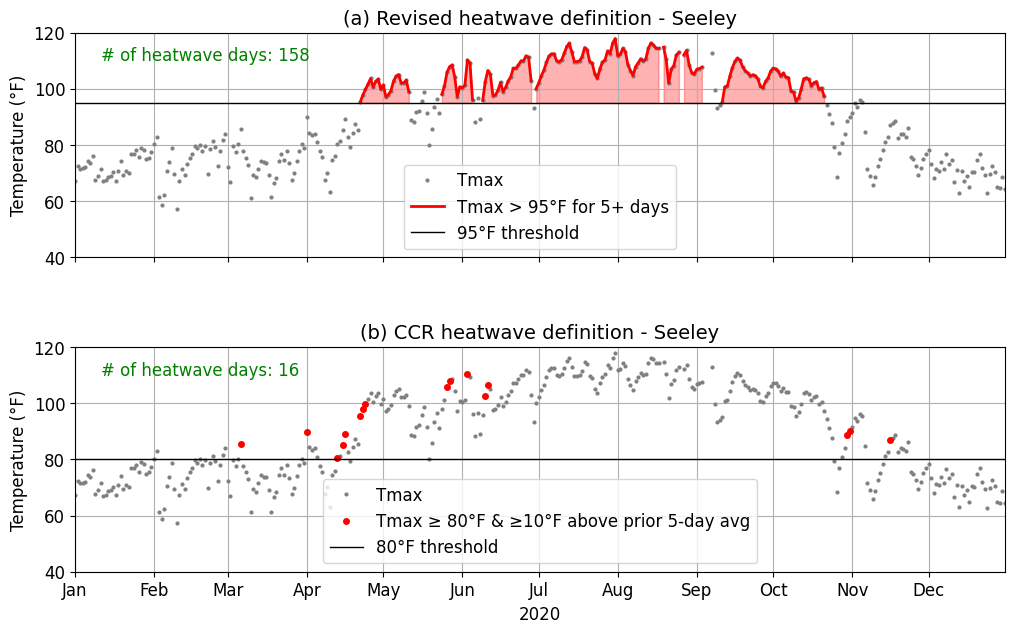

In [29]:
# Plot both definitions for Seeley

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Assuming data_daily_max[0], hw_fixed_stn0, ccr_hw_days_stn0, total_ccr_hw_days_stn0 are defined

# Create date range for the year 2020
dates = [datetime(2020, 1, 1) + timedelta(days=i) for i in range(366)]
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
threshold_fixed = 95.0  # °F


plt.rcParams.update({'font.size': 12})

# ---------- Fixed Threshold Plot Function ----------
def plot_fixed_heatwaves(ax, temps, heatwave_periods):
    ax.plot(dates, temps, 'o', color='grey', markersize=2, label='Tmax')
    for start, end in heatwave_periods:
        hw_dates = dates[start:end+1]
        hw_temps = temps[start:end+1]
        ax.plot(hw_dates, hw_temps, 'red', linewidth=2,
                label='Tmax > 95°F for 5+ days' if start == heatwave_periods[0][0] else "")
        ax.fill_between(hw_dates, threshold_fixed, hw_temps, where=np.array(hw_temps) > threshold_fixed,
                        interpolate=True, color='red', alpha=0.3)

    ax.axhline(threshold_fixed, color='black', linestyle='-', linewidth=1, label='95°F threshold')
    ax.set_ylabel("Temperature (°F)")
    ax.set_ylim(40, 120)
    ax.set_xlim([start_date, end_date])
    ax.grid(True)
    ax.legend()

# ---------- CCR Heatwave Plot Function ----------
def plot_ccr_heatwaves(ax, temps, hw_day_indices):
    ax.plot(dates, temps, 'o', color='grey', markersize=2, label='Tmax')

    # Plot CCR heatwave days as red markers
    hw_dates = [dates[i] for i in hw_day_indices]
    hw_temps = [temps[i] for i in hw_day_indices]
    ax.plot(hw_dates, hw_temps, 'o', color='red', markersize=4, label='Tmax ≥ 80°F & ≥10°F above prior 5-day avg')

    ax.axhline(80.0, color='black', linestyle='-', linewidth=1, label='80°F threshold')
    ax.set_ylabel("Temperature (°F)")
    ax.set_ylim(40, 120)
    ax.set_xlim([start_date, end_date])
    ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax.grid(True)
    ax.legend()

# ---------- Combined Plot for Station [0] ----------
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(2, 1, hspace=0.4)
axs = [fig.add_subplot(gs[i]) for i in range(2)]

# Plot only for station 0 (Seeley)
plot_fixed_heatwaves(axs[0], data_daily_max[0], hw_fixed_stn0)
axs[0].text(dates[10], 110, f'# of heatwave days: {hw_days_stn0}', color='green', fontsize=12)
axs[0].set_title("(a) Revised heatwave definition - Seeley", fontsize=14)
axs[0].set_yticks(np.arange(40, 121, 20))
axs[0].tick_params(labelbottom=False)

#

plot_ccr_heatwaves(axs[1], data_daily_max[0], ccr_hw_days_stn0)
axs[1].text(dates[10], 110, f'# of heatwave days: {total_ccr_hw_days_stn0}', color='green', fontsize=12)
axs[1].set_title("(b) CCR heatwave definition - Seeley", fontsize=14)
axs[1].set_xlabel("2020")
axs[1].set_yticks(np.arange(40, 121, 20))

axs[0].tick_params(labelbottom=False)
plt.show()


Now calculate WBGT from WRF outputs

In [30]:


# Install faster packages
!pip install thermofeel
!pip install netCDF4 h5netcdf

from matplotlib import pyplot as plt
import pandas as pd
import fsspec
import xarray as xr
import dask.array as da
import numpy as np

# Read lat/lon once
dataset_path = '/content/drive/MyDrive/python_colab_data/1km_apr_oct_sensor_select_new_irr.nc'
ds = xr.open_dataset(dataset_path, chunks={'time': 500})  # Add dask chunks
lat = ds['XLAT'].load()
lon = ds['XLONG'].load()
print(lat.shape)
print(lon.shape)

# Define a simple roll function to shift -8 steps
def shift_to_pst_da(da_array):
    # Shift time dimension by -7 (assuming first dim is time)
    return da.roll(da_array, shift=-7, axis=0)

# Variables you need
varnames = ['t2', 'psfc', 'u10', 'v10', 'swdnb', 'swupb', 'lwdnb', 'swddir', 'lwupb', 'coszen']

# Shift and slice each variable
shifted_vars = {}
for var in varnames:
    shifted_vars[var] = shift_to_pst_da(ds[var])[2760:3000, :, :]

# Close main dataset
ds.close()

# Load RH2M from second file
rh_ds = xr.open_dataset('/content/drive/MyDrive/python_colab_data/1km_apr_oct_sensor_select_new_rh2m_irr.nc', chunks={'time': 500})
rh = shift_to_pst_da(rh_ds['rh2m'])[2760:3000, :, :]
rh_ds.close()

shifted_vars['rh'] = rh;

# Calculate wind speed directly from dask arrays
shifted_vars['ws'] = np.sqrt(shifted_vars['u10']**2 + shifted_vars['v10']**2)

# Now calculate the ratio of the direct horizontal solar irradiance to the total horizontal solar irradiance (f)
shifted_vars['f'] = shifted_vars['swddir'] / shifted_vars['swdnb']

# Apply the conditions to adjust f
shifted_vars['f'] = np.where(shifted_vars['coszen'] <= np.cos(89.5 / 180 * np.pi), 0, shifted_vars['f'])
shifted_vars['f'] = np.where(shifted_vars['f'] > 0.9, 0.9, shifted_vars['f'])
shifted_vars['f'] = np.where(shifted_vars['f'] < 0, 0, shifted_vars['f'])
shifted_vars['f'] = np.where(shifted_vars['swdnb'] <= 0, 0, shifted_vars['f'])

(171, 162)
(171, 162)


In [31]:
# assign time dimension and spatial coordinates to the data

num_steps = 168
start_date = np.datetime64('2020-07-25 00:00')
end_date = np.datetime64('2020-08-03 23:00')
step_size = np.timedelta64(1, 'h')
dates = np.arange(start_date, end_date + step_size, step_size)
print(dates.shape)

# Create the time dimension using the new dates array
time_dim = dates

# Convert all variables in shifted_vars to xarray.DataArray objects using ds.coords and ds.dims
for key in shifted_vars:
    # For each variable in shifted_vars, we assign the new time dimension
    shifted_vars[key] = xr.DataArray(
        shifted_vars[key],
        coords={
            'time': time_dim,
            'south_north': ds.coords['south_north'],
            'west_east': ds.coords['west_east']
        },
        dims=['time', 'south_north', 'west_east']
    )

# Now all variables in shifted_vars have the correct time dimension and the right spatial coordinates




(240,)


In [32]:
# calculate WBGT using Kong and Huber (2022) script
import sys
sys.path.append('/content/drive/MyDrive/python_colab_data/Liljegren_code/PyWBGT-1.0.0/PyWBGT-1.0.0/src')

import os
!ls -al /content/drive/MyDrive/python_colab_data/Liljegren_code/PyWBGT-1.0.0/PyWBGT-1.0.0/src

os.chdir('/content/drive/MyDrive/python_colab_data/Liljegren_code/PyWBGT-1.0.0/PyWBGT-1.0.0/src')

from thermofeel import kelvin_to_fahrenheit;

# import functions for calculating WBGT
from WBGT import WBGT_Liljegren, WBGT_GCM
from WBGT import Tg_GCM, Tnwb_GCM


# Apply WBGT_GCM with parallelized Dask computation, including the 'False' parameter
wbgt_gcm_k = xr.apply_ufunc(
    WBGT_GCM,
    shifted_vars['t2'],
    shifted_vars['rh'],
    shifted_vars['psfc'],
    shifted_vars['ws'],
    shifted_vars['swdnb'],
    shifted_vars['swupb'],
    shifted_vars['lwdnb'],
    shifted_vars['lwupb'],
    shifted_vars['f'],
    shifted_vars['coszen'],
    False,  # Include the False parameter here
    dask="parallelized",  # This enables Dask parallelization
    output_dtypes=[float],
)

tnwb_gcm_k = xr.apply_ufunc(
    Tnwb_GCM,
    shifted_vars['t2'],
    shifted_vars['rh'],
    shifted_vars['psfc'],
    shifted_vars['ws'],
    shifted_vars['swdnb'],
    shifted_vars['swupb'],
    shifted_vars['lwdnb'],
    shifted_vars['lwupb'],
    shifted_vars['f'],
    shifted_vars['coszen'],
    False,  # Include the False parameter here
    dask="parallelized", # This enables Dask parallelization
    output_dtypes=[float],
)

tg_gcm_k = xr.apply_ufunc(
    Tg_GCM,
    shifted_vars['t2'],
    shifted_vars['psfc'],
    shifted_vars['ws'],
    shifted_vars['swdnb'],
    shifted_vars['swupb'],
    shifted_vars['lwdnb'],
    shifted_vars['lwupb'],
    shifted_vars['f'],
    shifted_vars['coszen'],
    False,  # Include the False parameter here
    dask="parallelized", # This enables Dask parallelization
    output_dtypes=[float],
)

total 245866
drwx------ 2 root root      4096 May 29 20:08 build
-rw------- 1 root root   1955473 May 29 20:09 coszenith.c
-rw------- 1 root root   2875376 May 29 20:13 coszenith.cpython-311-x86_64-linux-gnu.so
drwx------ 2 root root      4096 May 29 20:08 coszenith.egg-info
-rw------- 1 root root    952632 May 29 20:08 coszenith.html
-rw------- 1 root root     11125 Feb  6  2022 coszenith.pyx
-rw------- 1 root root       112 Feb  6  2022 .gitattributes
-rw------- 1 root root       477 May 29 20:11 setupcoszenith.py
-rw------- 1 root root       505 Jan 23 21:33 setupWBGT.py
-rw------- 1 root root 180607346 Jan 24 02:35 WBGT.c
-rw------- 1 root root  65313928 Jan 24 02:34 WBGT.cpython-311-x86_64-linux-gnu.so
-rw------- 1 root root     39063 Jan 23 20:22 WBGT.pyx


In [33]:
# Extract t2 and rh before deleting shifted_vars
t2 = shifted_vars['t2'].values
rh = shifted_vars['rh'].values
swdnb = shifted_vars['swdnb'].values
lwdnb = shifted_vars['lwdnb'].values
lwupb = shifted_vars['lwupb'].values

# Now delete the entire shifted_vars object to free up memory
del shifted_vars

In [34]:
# Until here, WBGT is actually not calculated, just a procedure is set. When we call below function, actual calculation is done so it takes more time.

wbgt_f = kelvin_to_fahrenheit(wbgt_gcm_k).compute().values
tnwb_f = kelvin_to_fahrenheit(tnwb_gcm_k).compute().values
tg_f = kelvin_to_fahrenheit(tg_gcm_k).compute().values
t2_f = kelvin_to_fahrenheit(t2)

# Then delete originals
del wbgt_gcm_k, tnwb_gcm_k, tg_gcm_k


print('min wbgt_f', wbgt_f.min())  # Use .min() on xarray DataArray
print('max wbgt_f', wbgt_f.max())

print('min tnwb_f', tnwb_f.min())
print('max tnwb_f', tnwb_f.max())

print('min tg_f', tg_f.min())
print('max tg_f', tg_f.max())


/usr/local/lib/python3.11/dist-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.11/dist-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.11/dist-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


min wbgt_f 31.044011867851488
max wbgt_f 110.45245509748622
min tnwb_f 27.6613223447589
max tnwb_f 93.33290487471574
min tg_f 37.338389688622485
max tg_f 169.85912251861072


In [35]:
import numpy as np
import pandas as pd


# From the model outputs, extract grids corresponding to station location using great circle method for TEMP

# Reshape the latitude and longitude dimensions of data_array for broadcasting

lat_all = np.stack([lat.values.ravel()]).T
lon_all = np.stack([lon.values.ravel()]).T

print(lat_all.shape)
print(lon_all.shape)

comb_lat_lon = np.concatenate((lat_all, lon_all), axis=1)
print(comb_lat_lon.shape)

# now for stations


station_lat = [32.759, 33.852620] # Seeley and Palm Spring
station_lon = [-115.732, -116.540990]


# Define station names
station_names = ['Seeley (Imperial Valley)', 'Palm Springs (Coachella Valley)']

# Stack lat and lon into one array
station_lat_lon = np.stack((station_lat, station_lon), axis=1)

# Create a pandas DataFrame for nice labeling
stations_df = pd.DataFrame(station_lat_lon, columns=['Latitude', 'Longitude'], index=station_names)

print(stations_df)


(27702, 1)
(27702, 1)
(27702, 2)
                                 Latitude  Longitude
Seeley (Imperial Valley)         32.75900 -115.73200
Palm Springs (Coachella Valley)  33.85262 -116.54099


In [36]:
# extract WRF model timeseries at the stations

!pip install haversine
from haversine import haversine
from haversine import haversine_vector, Unit



# Initialize an array to store the distances
distances = np.zeros((2, 27702))

# Loop through each pair of coordinates
for i in range(2):  # the first dimension in station_lat_lon
    for j in range(27702):  # the first dimension in comb_lat_lon
        # Compute haversine distance for the current pair of coordinates
        distances[i, j] = haversine_vector([station_lat_lon[i, :]],
                                           [comb_lat_lon[j, :]],
                                           Unit.DEGREES,
                                           comb=True)


# Find the index of the minimum distance for each station
min_distance_indices = np.argmin(distances, axis=1)
min_distance_indices
# Convert the 1D indices to multidimensional indices
indices = np.unravel_index(min_distance_indices, [171, 162])
indices

# Extract data for the closest grid points

closest_data_sensor_wbgt = wbgt_f[:, indices[0], indices[1]]
closest_data_sensor_wbgt.shape
closest_data_sensor_wbgt_new = closest_data_sensor_wbgt.T
print(closest_data_sensor_wbgt_new.shape)

# TNWB
closest_data_sensor_tnwb = tnwb_f[:, indices[0], indices[1]]
closest_data_sensor_tnwb_new = closest_data_sensor_tnwb.T
print(closest_data_sensor_tnwb_new.shape)

# TG
closest_data_sensor_tg = tg_f[:, indices[0], indices[1]]
closest_data_sensor_tg_new = closest_data_sensor_tg.T
print(closest_data_sensor_tg_new.shape)

# T2
closest_data_sensor_t2 = t2_f[:, indices[0], indices[1]]
closest_data_sensor_t2_new = closest_data_sensor_t2.T
print(closest_data_sensor_t2_new.shape)

# RH
closest_data_sensor_rh = rh[:, indices[0], indices[1]]
closest_data_sensor_rh_new = closest_data_sensor_rh.T
print(closest_data_sensor_rh_new.shape)

# SWDNB
closest_data_sensor_swdnb = swdnb[:, indices[0], indices[1]]
closest_data_sensor_swdnb_new = closest_data_sensor_swdnb.T
print(closest_data_sensor_swdnb_new.shape)

# LWDNB
closest_data_sensor_lwdnb = lwdnb[:, indices[0], indices[1]]
closest_data_sensor_lwdnb_new = closest_data_sensor_lwdnb.T
print(closest_data_sensor_lwdnb_new.shape)

# LWUPB
closest_data_sensor_lwupb = lwupb[:, indices[0], indices[1]]
closest_data_sensor_lwupb_new = closest_data_sensor_lwupb.T
print(closest_data_sensor_lwupb_new.shape)

/tmp/ipython-input-36-2968228112.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distances[i, j] = haversine_vector([station_lat_lon[i, :]],


(2, 240)
(2, 240)
(2, 240)
(2, 240)
(2, 240)
(2, 240)
(2, 240)
(2, 240)


In [37]:
!pip install cartopy
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.ticker import MultipleLocator

# Load the county and lake shapefiles
counties = gpd.read_file("/content/drive/MyDrive/python_colab_data/County_Boundaries/County_Boundaries.shp")
salton = gpd.read_file("/content/drive/MyDrive/python_colab_data/Salton_geog/Salton_geog.shp")

/tmp/ipython-input-38-1046031544.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='lower right', fontsize=12)
/tmp/ipython-input-38-1046031544.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='lower right', fontsize=12)
/tmp/ipython-input-38-1046031544.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='lower right', fontsize=12)
/tmp/ipython-input-38-1046031544.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc='lower r

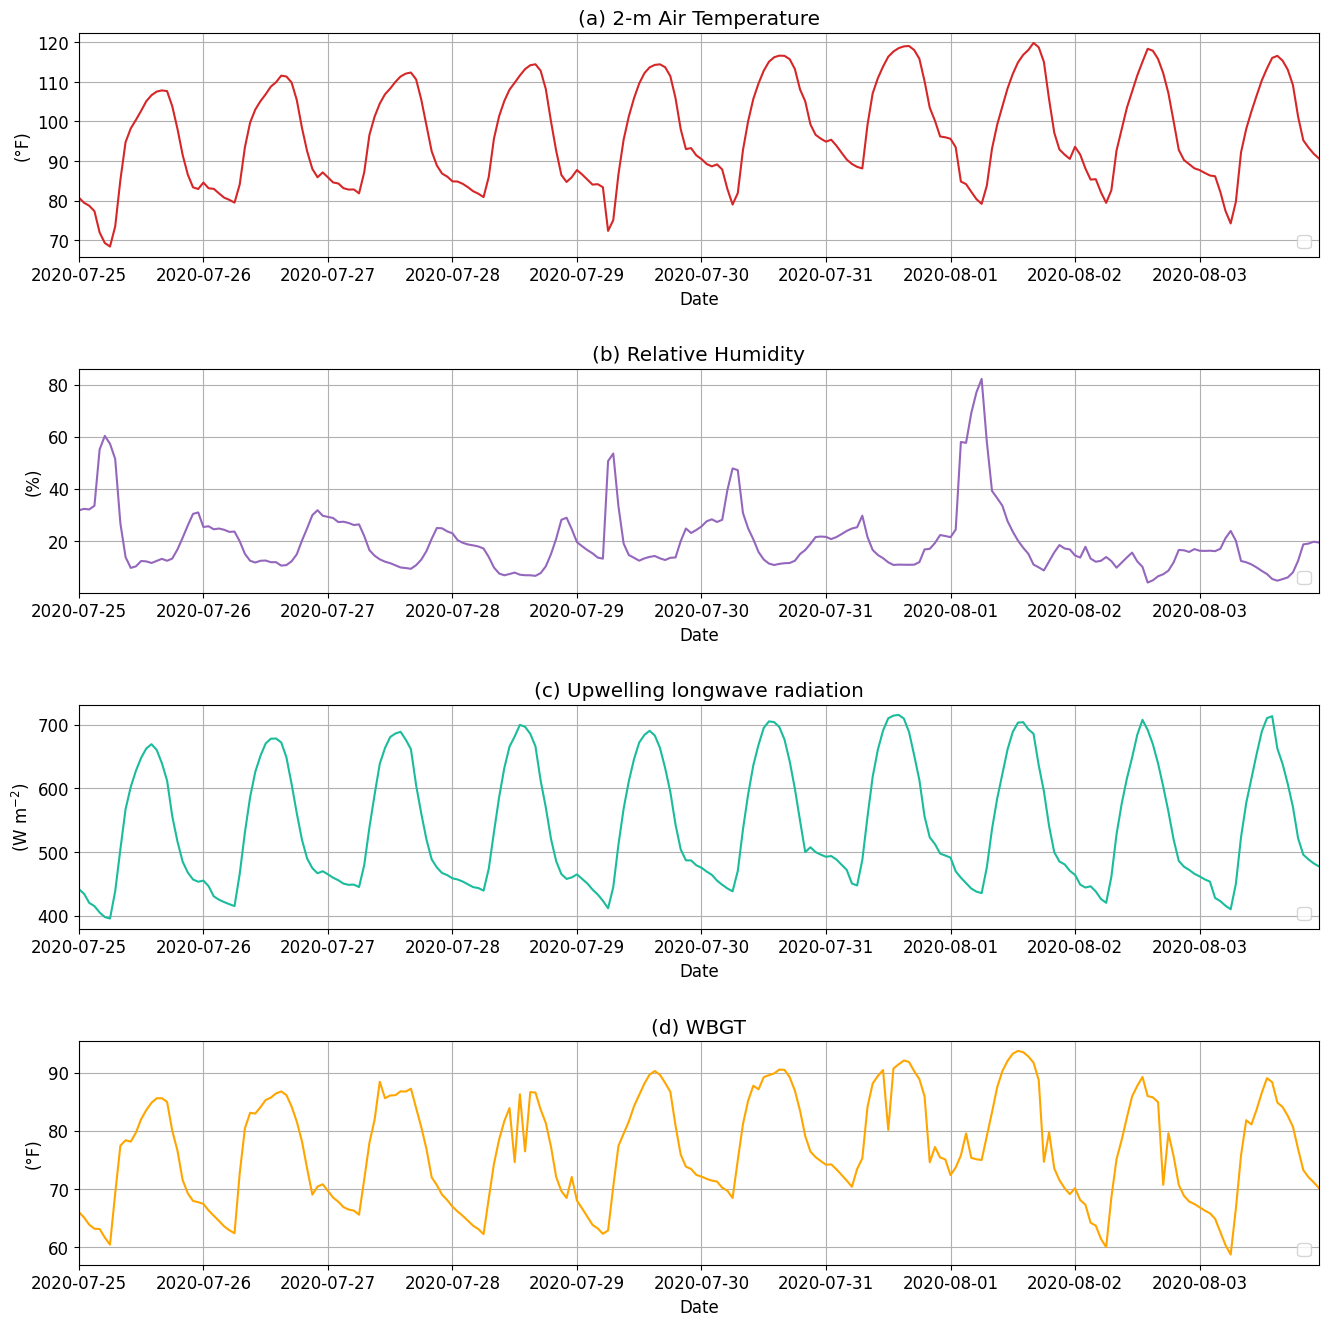

In [38]:
# plot timeseries

# plot comparision figures for all stations

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12})

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5)

ax1.plot(dates[:], np.ma.masked_invalid(closest_data_sensor_t2_new[0, :]), marker='', linestyle='-', color='#d62728')
ax1.set_title('(a) 2-m Air Temperature')
ax1.set_xlabel('Date')
ax1.set_xlim([start_date, end_date])
ax1.tick_params(axis='x', labelrotation=0)
ax1.set_ylabel('(°F)')
ax1.grid(True)
ax1.legend(loc='lower right', fontsize=12)


ax2.plot(dates[:], np.ma.masked_invalid(closest_data_sensor_rh_new[0, :]), marker='', linestyle='-', color='#9467bd')
ax2.set_title('(b) Relative Humidity')
ax2.set_xlabel('Date')
ax2.set_xlim([start_date, end_date])
ax2.tick_params(axis='x', labelrotation=0)
ax2.set_ylabel('(%)')
ax2.grid(True)
ax2.legend(loc='lower right', fontsize=12)

ax3.plot(dates[:], np.ma.masked_invalid(closest_data_sensor_lwupb_new[0, :]), marker='', linestyle='-', color='#1ABC9C')
ax3.set_title('(c) Upwelling longwave radiation')
ax3.set_xlabel('Date')
ax3.set_xlim([start_date, end_date])
ax3.tick_params(axis='x', labelrotation=0)
ax3.set_ylabel('(W m$^{-2}$)')
ax3.grid(True)
ax3.legend(loc='lower right', fontsize=12)

ax4.plot(dates[:], np.ma.masked_invalid(closest_data_sensor_wbgt_new[0, :]), marker='', linestyle='-', color='orange')
ax4.set_title('(d) WBGT')
ax4.set_xlabel('Date')
ax4.set_xlim([start_date, end_date])
ax4.tick_params(axis='x', labelrotation=0)
ax4.set_ylabel('(°F)')
#ax1.tick_params(axis='both', labelsize=8)
ax4.grid(True)
ax4.legend(loc='lower right', fontsize=12)

#plt.savefig('/content/drive/MyDrive/Google_Drive_UTmail/SDSU/Figures/timeseries_heatwave.png', bbox_inches='tight', dpi=400)

plt.show()
